In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy,mean_squared_error

from technicalSignals import momentum,SMA,inBBands





# #CPU RUN
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [23]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
tickers=['AAPL']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,50)]
kind_of_dataset = 'AffectiveSpace'
NN_INPUT_DIM = 716


In [24]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = momentum(price, 30)
            price['mom_50'] = momentum(price, 50)
            price['mom_100'] = momentum(price, 100)
            price['mom_150'] = momentum(price, 150)
            price['SMA_30'] = SMA(price, 30)
            price['SMA_50'] = SMA(price, 50)
            price['SMA_100'] = SMA(price, 100)
            price['SMA_150'] = SMA(price, 150)
            price['in_BBands'] = inBBands(price)

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
        y = self.normalize(np.array(y))
        #y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt = math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def normalize(self, values):
        m = min(values)
        M = max(values)
        values = 2*(values-m)/(M-m)-1
        return values
    
    def get_dataset_for_trend_all_tickers(self, init, finish,kind, perc_train = 0.7, technicalFeatures=False):
        x_tv_all = []
        y_tv_all = []
        x_test_all = []
        y_test_all = []
        dates_test_prev = None
        for ticker in tickers:
            self.load_dataset(ticker, kind, technicalFeatures)
            (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
            if(dates_test_prev):
                assert dates_test == dates_test_prev #I'm not secure about this constraint but otherwise which dates I will output?
            x_tv_all += x_tv.tolist()
            y_tv_all += y_tv.tolist()
            x_test_all += x_test.tolist()
            y_test_all += y_test.tolist()
        x_tv_all = np.asarray(x_tv_all)
        y_tv_all = np.asarray(y_tv_all)
        x_test_all = np.asarray(x_test_all)
        y_test_all = np.asarray(y_test_all)
        return (x_tv_all,y_tv_all),(x_test_all,y_test_all), dates_test

In [25]:
def weighted_MSE(y_true, y_pred):
    weights = K.pow(y_true,2)
    m = K.min(weights)
    M = K.max(weights)
    weights = (weights-m)/(M-m)
    return mean_squared_error(y_true,y_pred)*weights


# def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
#     #dropout is the probability of retaining a unit (contrary of paper)
#     n_units = math.floor(n_expected_active_units / (1 - dropout))
#     model = Sequential()
#     model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
#     model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
#     model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
#     model.add(Dropout(dropout))
#     model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
#     model.add(BatchNormalization()) 
#     model.add(LeakyReLU())
#     model.add(Dropout(dropout))
#     model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
#     model.add(BatchNormalization()) 
#     model.add(LeakyReLU()) 
#     model.add(Dense(1, activation='tanh')) 
#     #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) OFFICIAL
#     opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
#     return model

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout))
    model = Sequential()
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return model


def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,y_pred,y_test,l2,drop,n_units):
    f, axarr = plt.subplots(2)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(y_test,'g', label='y_test')
    axarr[0].plot(y_pred,'r', label='y_pred')
    axarr[1].semilogy(history.history['loss'],'g--',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r--',label='loss_val')
    axarr[1].semilogy(history.history['val_weighted_MSE'],'b:',label='loss_val_WITH_W')
    axarr[1].semilogy(history.history['weighted_MSE'],'g:',label='loss_WITH_W')
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show()
    print('Min val loss: ', min(history.history['val_loss']))
    print('Val loss: ', history.history['val_loss'][-1])

            
            
def cv(x_tv,y_tv):
    l2_space=[0.1,0.05,0.01]
    drop_space=[0.2,0.5,0.7]
    max_norm_space=[1,3,5,10,20]
    drop_space=[0.5]
    n_unit_space=[8, 16, 32]
    
    
    max_norm_space=[1,3,5,10,20,40]
    drop_space=[0.5]
    n_unit_space=[8, 16, 32, 64]
    
    best_mse = float(np.inf)
    best_l2 = 0
    best_drop = 0
    best_n_units = 0
    for l2 in max_norm_space:
        for drop in drop_space:
            for n_units in n_unit_space:
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMSE = 0
                #nn_model = buildNN(l2_regularizer=l2,n_units=n_units,dropout=drop)
                nn_model = buildNN2(n_expected_active_units=n_units, dropout = drop, max_norm_val = l2)
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    weights = np.power(y_train,2)
                    m = min(weights)
                    M = max(weights)
                    weights = (weights-m)/(M-m)
                    history = nn_model.fit(x_train, y_train, epochs = 1000,batch_size =256, verbose=0, 
                                           validation_data=(x_val, y_val),shuffle=True,
                                           sample_weight = weights)
#                     history = nn_model.fit(x_train, y_train, epochs = 200,batch_size =256, verbose=0, 
#                                            validation_data=(x_val, y_val),shuffle=True)
                    mse = history.history['val_loss'][-1]
                    y_pred = nn_model.predict(x_val, batch_size=256, verbose=0)
                    cvMSE += mse/4
                    reset_weights(nn_model)
                if(cvMSE < best_mse):
                    best_mse = cvMSE
                    best_l2 = l2
                    best_drop = drop
                    best_n_units = n_units
                #plot_hystory(history,y_pred,y_val,l2,drop,n_units)  
                
    return (best_l2,best_drop,best_n_units)




====================  trend:  1   50  ==================== 



AAPL
(5, 0.5, 32)
==== Test ===


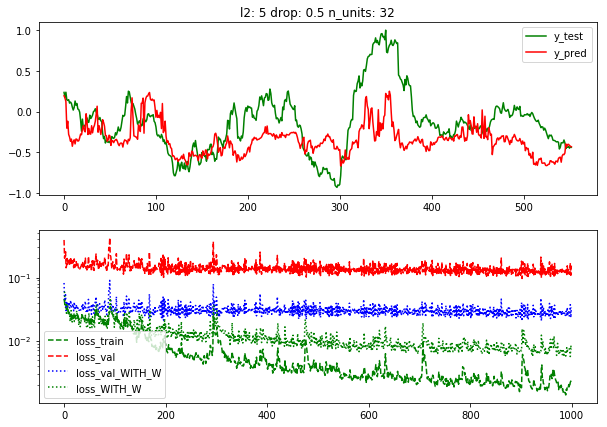

Min val loss:  0.09645954828716101
Val loss:  0.15382277221834897


In [26]:
for (init, finish) in TREND_WINDOWs:
    print('\n\n\n====================  trend: ',init,' ',finish, ' ==================== \n\n')
    for ticker in tickers:
        print('\n'+ticker)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        #(best_l2,best_drop,best_n_units) = cv(x_tv,y_tv)
        # AAPL (5, 0.5, 32)
        # GOOGL (1, 0.5, 8)
        (best_l2,best_drop,best_n_units) = (5, 0.5, 32)
        print((best_l2,best_drop,best_n_units))
        nn_model = buildNN2(n_expected_active_units=best_n_units, dropout = best_drop, max_norm_val = best_l2)
        weights = np.power(y_tv,2)
        m = min(weights)
        M = max(weights)
        weights = (weights-m)/(M-m)
        history = nn_model.fit(x_tv, y_tv, epochs = 1000,batch_size =256, verbose=0,
                               validation_data=(x_test, y_test),shuffle=True, sample_weight = weights)
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        print('==== Test ===')
        plot_hystory(history,y_pred,y_test,best_l2,best_drop,best_n_units)  
        